https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data



In [6]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "Stock_Data/Stocks"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1a-I9epOaGdMqEQjvMO-SGs4iDefnoraJ/Stocks


In [7]:
"""LSTM Model"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


import plotly.graph_objects as go

import xgboost as xgb

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

class PriceClassifier():

  stock: str
  stock_history_df: pd.DataFrame
  model: Sequential

  def __init__(self, stock: str):
    self.stock = stock
    self.stock_history_df = self._get_stock_history_df()
    self.train_data, self.test_data, self.val_data = self._create_train_and_test_set()
    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test = self._preprocess()

  def _get_stock_history_df(self):
    stock_country = "us"
    stock_history_path = f"{self.stock}.{stock_country}.txt"
    return pd.read_csv(stock_history_path)

  def plot_daily_close(self):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='Close', data=self.stock_history_df)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title('AMTD daily close price 2010-2017')
    plt.show()

  def _create_train_and_test_set(self):
    train_size = 0.8
    test_size = 0.1
    validation_size = 0.1
    dataset = self.stock_history_df

    train_end = int(len(dataset) * train_size)
    test_end = train_end + int(len(dataset) * test_size)

    train_data = dataset.iloc[:train_end]
    test_data = dataset.iloc[train_end:test_end]
    validation_data = dataset.iloc[test_end:]
    return train_data, test_data, validation_data

  def plot_train_test_val(self):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=self.train_data['Date'], y=self.train_data['Close'], mode='lines', name='Train data'))
    fig.add_trace(go.Scatter(x=self.test_data['Date'], y=self.test_data['Close'], mode='lines', name='Test data'))
    fig.add_trace(go.Scatter(x=self.val_data['Date'], y=self.val_data['Close'], mode='lines', name='Validation data'))


    fig.update_layout(
        title=f'{self.stock.upper()} daily close price 2010-2017',
        xaxis_title='Date',
        yaxis_title='Close price',
    )

    fig.show()

  def _preprocess(self):
    X_train = self.train_data.drop(columns=['Close', 'Date'])
    y_train = self.train_data['Close']
    X_validation = self.val_data.drop(columns=['Close', 'Date'])
    y_validation = self.val_data['Close']
    X_test = self.test_data.drop(columns=['Close', 'Date'])
    return X_train, y_train, X_validation, y_validation, X_test

  def train(self, model=None, optimizer=None, epochs=50, batch_size=32, loss="mean_squared_error"):
    if not model:
      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(self.X_train.shape[1], 1)))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50))
      model.add(Dropout(0.2))
      model.add(Dense(units=1))

    if not optimizer:
      optimizer = Adam()
    model.compile(optimizer=optimizer,loss=loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(self.X_train,self.y_train,epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(self.X_val, self.y_val),
                        callbacks=[early_stopping])
    self.model = model

  def predict(self, plot=True):
    test_preds = self.model.predict(self.X_test)
    if plot:
      plt.figure(figsize=(10, 6))
      plt.plot(self.test_data['Date'], self.test_data['Close'], label='Actual')
      plt.plot(self.test_data['Date'], test_preds, label='Predicted')
      plt.xlabel('Date')
      plt.ylabel('Close Price')
      plt.title(f'Actual vs. Test {self.stock.upper()} daily close prices')
      plt.legend()
      plt.xticks([])
      plt.tight_layout()
      plt.show()
    return test_preds


In [7]:
## Example of how to load a single stock into a Pandas Dataframe.
amtd_model = PriceClassifier("amtd")
amtd_model.stock_history_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,7.1722,7.3563,7.1457,7.2511,5375043,0
1,2005-02-28,7.2949,7.3388,7.1194,7.1808,4602417,0
2,2005-03-01,7.1808,7.2597,7.1194,7.1808,5648916,0
3,2005-03-02,7.1457,7.5493,7.0931,7.4439,10262412,0
4,2005-03-03,7.4879,7.6632,7.2949,7.3299,5287947,0


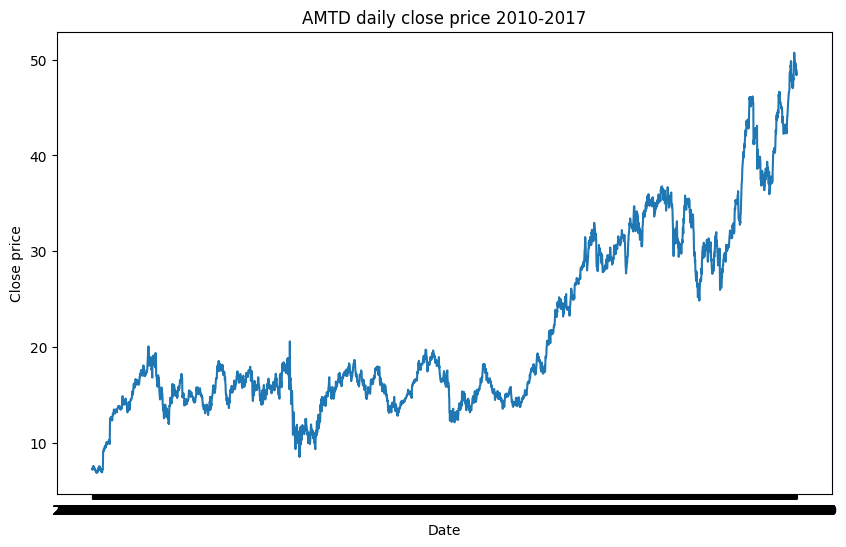

In [8]:
amtd_model.plot_daily_close()

In [9]:
amtd_model.plot_train_test_val()

In [4]:
amtd_model.train()

NameError: ignored

10/10 [==============================] - 2s 5ms/step


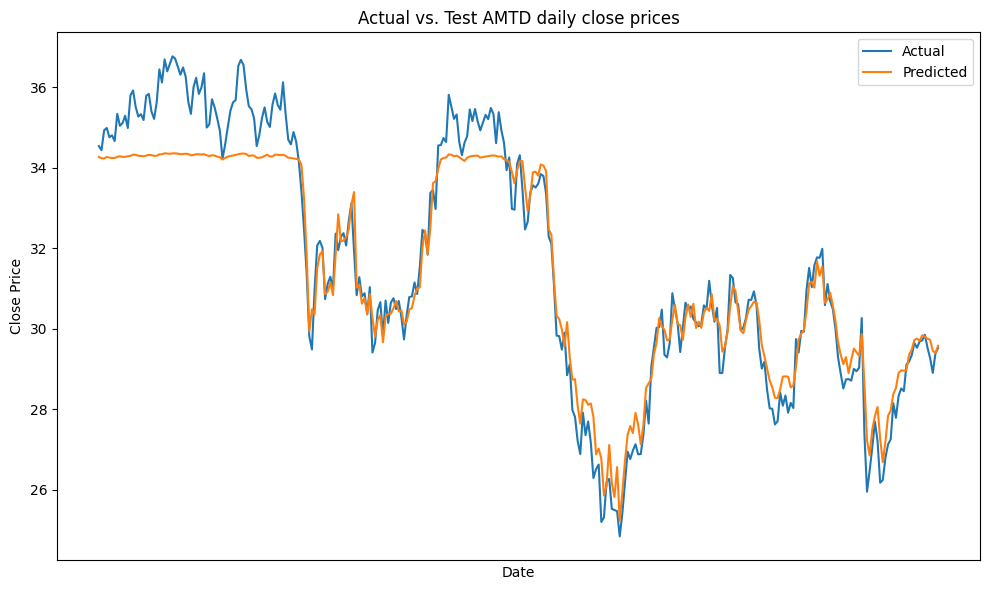

In [11]:
amtd_model.predict()

In [12]:
from keras.optimizers import Adam
from keras import regularizers
msft_model = PriceClassifier("ibm")
model = Sequential()
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3), return_sequences=True))
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3)))

model.add(Dense(units=1))
optimizer = Adam()
msft_model.train(model=model, optimizer=optimizer, epochs=50, loss="mean_squared_error")

Epoch 1/50
352/352 [==============================] - 7s 8ms/step - loss: 812.2406 - val_loss: 17849.9922
Epoch 2/50
352/352 [==============================] - 2s 7ms/step - loss: 461.3120 - val_loss: 14288.6152
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 257.7586 - val_loss: 11644.3203
Epoch 4/50
352/352 [==============================] - 3s 9ms/step - loss: 147.2009 - val_loss: 9716.6191
Epoch 5/50
352/352 [==============================] - 3s 8ms/step - loss: 85.0433 - val_loss: 8327.5264
Epoch 6/50
352/352 [==============================] - 2s 7ms/step - loss: 54.9280 - val_loss: 7351.2915
Epoch 7/50
352/352 [==============================] - 2s 6ms/step - loss: 35.5760 - val_loss: 6588.2764
Epoch 8/50
352/352 [==============================] - 3s 10ms/step - loss: 26.5571 - val_loss: 5970.4507
Epoch 9/50
352/352 [==============================] - 4s 12ms/step - loss: 21.4225 - val_loss: 5457.4341
Epoch 10/50
352/352 [==============================] - 

44/44 [==============================] - 1s 3ms/step


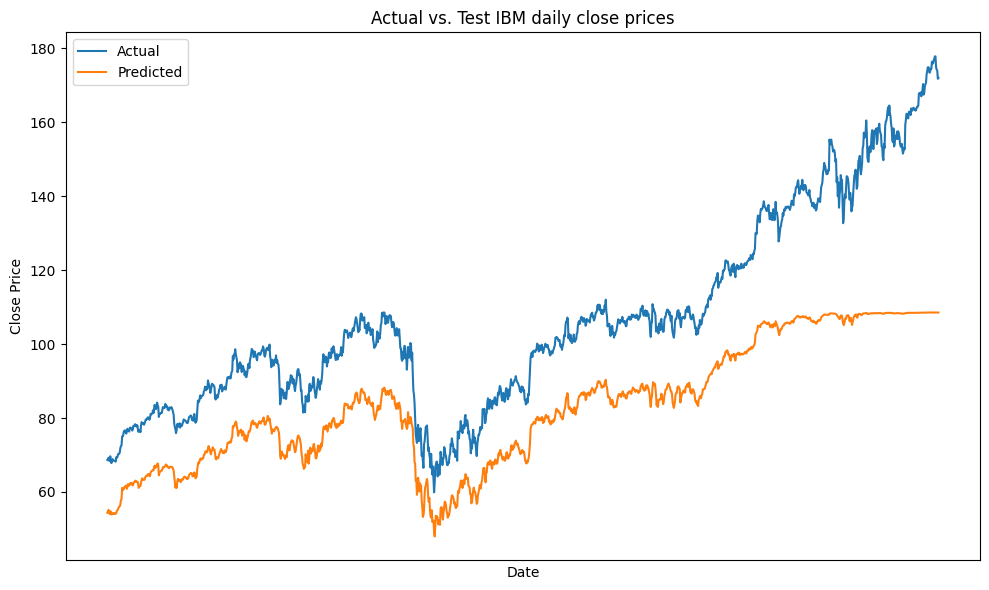

In [13]:
msft_model.predict()

In [9]:
amtd_model = PriceClassifier("amtd")
amtd_model.train()
msft_model = PriceClassifier("msft")
msft_model.train()

Epoch 1/50
80/80 [==============================] - 14s 25ms/step - loss: 156.3134 - val_loss: 811.8425
Epoch 2/50
80/80 [==============================] - 1s 11ms/step - loss: 54.4042 - val_loss: 655.7717
Epoch 3/50
80/80 [==============================] - 1s 11ms/step - loss: 42.3069 - val_loss: 580.4987
Epoch 4/50
80/80 [==============================] - 1s 12ms/step - loss: 39.7630 - val_loss: 550.7536
Epoch 5/50
80/80 [==============================] - 1s 13ms/step - loss: 39.0157 - val_loss: 540.6953
Epoch 6/50
80/80 [==============================] - 1s 12ms/step - loss: 39.5857 - val_loss: 539.4595
Epoch 7/50
80/80 [==============================] - 1s 12ms/step - loss: 39.8291 - val_loss: 536.7840
Epoch 8/50
80/80 [==============================] - 1s 12ms/step - loss: 38.8436 - val_loss: 540.3488
Epoch 9/50
80/80 [==============================] - 1s 9ms/step - loss: 39.7219 - val_loss: 534.9534
Epoch 10/50
80/80 [==============================] - 1s 9ms/step - loss: 39.7565 

In [55]:
from math import floor
class Portfolio:

  def __init__(self, models):
    #import pdb
    #pdb.set_trace()
    self.models = models
    self.account_value = 10000
    self.last_known_prices = [list(model.train_data["Close"])[-1] for model in models]
    self.assets_held = [floor(self.account_value / len(models) / price) for price in self.last_known_prices]
    self.cash_held = self.account_value - sum(num_share * price for num_share, price in zip(self.assets_held, self.last_known_prices))

  def manage(self):
    tick = 20 # ~20 business days in a month
    forward_look = 100 # Look forward 100 days to see if stock will go up or down
    test_preds = [model.predict(plot=False) for model in self.models]
    index = 0
    for index, date in enumerate(self.models[0].test_data["Date"]):

      print(f"Date {date}")
      test_preds_at_date = [pred[index] for pred in test_preds]
      print(test_preds_at_date)
      differences = []
      for model_index, test_pred_at_date in enumerate(test_preds_at_date):
        stock = self.models[model_index].stock
        if index + forward_look < len(test_preds[model_index]):
          print(f"Price for {stock} on {date} was {test_pred_at_date}")
          forward_price = test_preds[model_index][index + forward_look]
          print(f"Looking forward {forward_look} days price will be {forward_price}")
          difference = forward_price - test_pred_at_date
          print(f"Difference {difference}")
          differences.append(difference)

      # SELL Overvalued
      most_overvalued = min(differences)
      most_overvalued_stock_index = differences.index(most_overvalued)
      price = test_preds_at_date[most_overvalued_stock_index]
      self.sell(most_overvalued_stock_index, most_overvalued, price)


      # BUY Undervalued
      most_undervalued = max(differences)
      most_undervalued_stock_index = differences.index(most_undervalued)
      price = test_preds_at_date[most_undervalued_stock_index]

      self.buy(most_undervalued_stock_index, most_undervalued, price)
  def sell(self, stock_index, difference, price):
    stock = self.models[stock_index].stock
    threshold_to_sell = -3
    if difference < threshold_to_sell:
      shares_to_sell = floor(.9 * self.assets_held[stock_index])
      print(f"SELLING {shares_to_sell} of {stock} @ {price}")
      self.assets_held[stock_index] -= shares_to_sell
      self.cash_held += shares_to_sell * price
      self.account_balance()

  def buy(self, stock_index, difference, price):
    stock = self.models[stock_index].stock
    threshold_to_buy = 3
    #import pdb
    #pdb.set_trace()
    if difference > threshold_to_buy:
      shares_to_buy = floor(.9 * self.cash_held/self.assets_held[stock_index])
      print(f"BUYING {shares_to_buy} of {stock} @ {price}")
      self.cash_held -= shares_to_buy * price
      self.assets_held[stock_index] += shares_to_buy
      self.account_balance()

  def get_stock_str(self, stock_index):
    return self.models[stock_index].stock


  def account_balance(self):
    total_value = 0
    for index, num_stock in enumerate(self.assets_held):
      print(f"{self.get_stock_str(index)}: {num_stock} @ {self.last_known_prices[index]}")
      total_value += num_stock * self.last_known_prices[index]
    print(f"Cash: {self.cash_held}")
    total_value += self.cash_held
    print(f"Total Value: {total_value}")
    return total_value

In [58]:
portfolio = Portfolio([amtd_model, msft_model])
initial_balance = portfolio.account_balance()
portfolio.manage()
final_balance = portfolio.account_balance()
rate_of_return = (final_balance - initial_balance)/initial_balance

print(f"\n\n\n\nInitial Balance {initial_balance}\nFinal Balance: {final_balance}\nRate of Return {rate_of_return}")

amtd: 142 @ 35.029
msft: 222 @ 22.478
Cash: 35.76599999999962
Total Value: 10000.0
25/25 [==============================] - 0s 4ms/step
Date 2015-04-30
[array([33.728397], dtype=float32), array([22.18601], dtype=float32)]
Price for amtd on 2015-04-30 was [33.728397]
Looking forward 100 days price will be [29.681034]
Difference [-4.0473633]
Price for msft on 2015-04-30 was [22.18601]
Looking forward 100 days price will be [21.557245]
Difference [-0.6287651]
SELLING 127 of amtd @ [33.728397]
amtd: 15 @ 35.029
msft: 222 @ 22.478
Cash: [4319.2725]
Total Value: [9834.823]
Date 2015-05-01
[array([33.574436], dtype=float32), array([22.301125], dtype=float32)]
Price for amtd on 2015-05-01 was [33.574436]
Looking forward 100 days price will be [29.877354]
Difference [-3.6970825]
Price for msft on 2015-05-01 was [22.301125]
Looking forward 100 days price will be [21.543411]
Difference [-0.7577133]
SELLING 13 of amtd @ [33.574436]
amtd: 2 @ 35.029
msft: 222 @ 22.478
Cash: [4755.74]
Total Value: [

--------------------------------------------------------------------------------


Correlation Stuff

In [14]:
import pandas as pd
import glob

# List all CSV files in the current directory
csv_files = ['aa.us.txt', 'abb.us.txt', 'aau.us.txt']

# Create an empty DataFrame to store merged data
merged_data = None

# Read and merge data from all CSV files
for file in csv_files:
    stock_data = pd.read_csv(file)
    if merged_data is None:
      merged_data = stock_data
    else:
      merged_data = pd.merge(merged_data, stock_data, on='Date', how='outer')

merged_data.dropna(inplace=True)
print(merged_data.head())

# Calculate correlation for each pair of stocks
correlation_matrix = merged_data.corr()

print(correlation_matrix)


            Date  Open_x  High_x   Low_x  Close_x  Volume_x  OpenInt_x  \
8872  2005-02-25  65.687  66.812  65.561   66.039   2935168          0   
8873  2005-02-28  66.565  67.170  66.290   67.063   3229626          0   
8874  2005-03-01  67.042  67.421  65.875   66.104   2386346          0   
8875  2005-03-02  65.561  66.016  64.770   65.353   1973783          0   
8876  2005-03-03  65.977  66.227  64.889   65.310   1857445          0   

      Open_y  High_y   Low_y  Close_y  Volume_y  OpenInt_y  Open  High   Low  \
8872  4.4844  4.5556  4.4765   4.5082  319324.0        0.0  1.58  1.58  1.53   
8873  4.5873  4.5873  4.4685   4.5082  534773.0        0.0  1.64  1.64  1.54   
8874  4.5479  4.5873  4.5399   4.5717  409945.0        0.0  1.53  1.61  1.53   
8875  4.5717  4.5954  4.5399   4.5636  239933.0        0.0  1.53  1.53  1.53   
8876  4.6112  4.6666  4.5873   4.6270  962639.0        0.0  1.54  1.54  1.49   

      Close   Volume  OpenInt  
8872   1.58   8570.0      0.0  
8873   1.6